# Project 7 - Create a model to predict the revenues of potential customers using ANOVA and Linear Regression.

🎯 Goal: Create a model to predict the future revenue of children based on their location, the revenue of their parents and the gini index; in order to target future customers.

## Part 4 - Modeling

Here are the hypothesis for the tests:
- H0 – There is no significant difference among the groups. What we observe is the random noise due to the sampling effect.
- H1 – There is a significant difference among the groups

If the p-value is below 0.05, we reject the null hypothesis in favor of the alternative: this means that at least one group mean is significantly different.

### Get started

In [60]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats  
import seaborn as sns
from statsmodels.compat import lzip
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.tsa.api as smt
import statsmodels.stats.api as sms
from statsmodels.stats.diagnostic import linear_harvey_collier
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn import preprocessing
import scipy.stats as st
import statsmodels.stats.stattools as tool
import random
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
import pingouin as pg

%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [2]:
# Function to extract only the features to evaluate the performances of the model
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']

    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])

    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])

    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

In [3]:
# Read the data with parent's class and child revenues
df = pd.read_csv(Path.cwd()/'Processed'/'final_dataset.csv',index_col=0)

/Users/aureliegiraud/.virtualenvs/env3.8/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
# Read data with Gini index and Average income by country
inc_avg = pd.read_csv(Path.cwd()/'Processed'/'worldbank_avg.csv',index_col=0)

In [5]:
# Compile all together
df = pd.merge(df, inc_avg[['name','new_gini','income']], on = 'name', how = 'inner')
df.rename(columns= {'income_x':'income','income_y':'avg_income'},inplace=True)
df.head()

,name,c_i_parent,income,new_gini,avg_income
0,Albania,1,728.89795,32.141019,2994.829902
1,Albania,1,728.89795,32.141019,2994.829902
2,Albania,1,728.89795,32.141019,2994.829902
3,Albania,1,728.89795,32.141019,2994.829902
4,Albania,1,728.89795,32.141019,2994.829902


### ANOVA

In this notebook, ANOVA is applied to verify the effect of a qualitative variable (country's name) on a quantitative variable (income).

#### Country ~ Income 

/Users/aureliegiraud/.virtualenvs/env3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='income', ylabel='Density'>

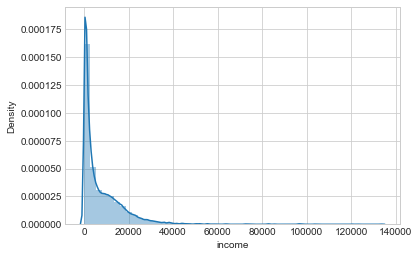

In [41]:
# Quick view on the distribution of income
sns.distplot(df.income)

/Users/aureliegiraud/.virtualenvs/env3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='income', ylabel='Density'>

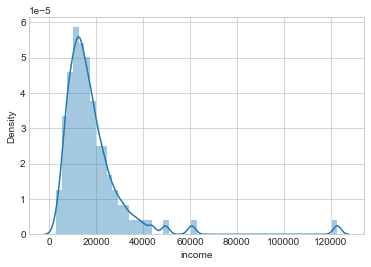

In [42]:
# Example with France
tmp = df[df.name == 'France']
sns.distplot(tmp.income)

<b> As expected, the distribution of income is skew to the right - meaning that there are some very high incomes. </b> Because of this profile, which is not really following a Gaussian-like distribution, we can expect the model, to not perform very well.

In [43]:
# ANOVA 1-way with income values
model = ols('income ~ C(name)',data = df).fit()
table = sm.stats.anova_lm(model,type=2)
anova_table(table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(name),1.167181e+14,50.0,2.334362e+12,42349.629417,0.0,0.466162,0.46615
Residual,1.336631e+14,2424895.0,5.512119e+07,NaN,NaN,NaN,NaN


<b> If we check the “basics” parameters, here is what we can see:</b>
- Eta-squared is low, which might indicates that the model is not fitting well the data.
- The model sum of square is slightly lower than the error sum of square, which means that a big part of the total variability of the observed data still remains unexplained.
- The MSE is high in both cases - for the variable and for the residual, which indicates again that the model is not performing well to fit and predict the data.


- p-value << alpha risk (5%), meaning that at least one group is different than the rest (so that the income depend on the country). 

<div class = 'alert alert-block alert-info'> Let's try if we can improve the model by transforming the income with a log function. </div>

#### Country ~ Log_income

In [6]:
# Apply Log Transformation
df['log_income'] = np.log2(df['income'])
df.head()

,name,c_i_parent,income,new_gini,avg_income,log_income
0,Albania,1,728.89795,32.141019,2994.829902,9.509573
1,Albania,1,728.89795,32.141019,2994.829902,9.509573
2,Albania,1,728.89795,32.141019,2994.829902,9.509573
3,Albania,1,728.89795,32.141019,2994.829902,9.509573
4,Albania,1,728.89795,32.141019,2994.829902,9.509573


/Users/aureliegiraud/.virtualenvs/env3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='log_income', ylabel='Density'>

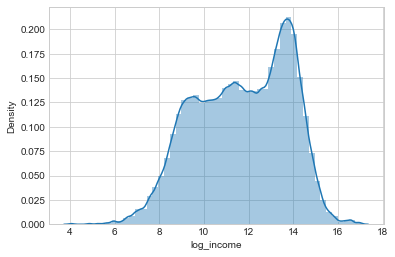

In [45]:
# Quick view on the distribution of log income
sns.distplot(df.log_income)
plt.savefig(Path.cwd()/'Plot'/'BoxPlot_LOGIncome_Countries.png')

/Users/aureliegiraud/.virtualenvs/env3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='log_income', ylabel='Density'>

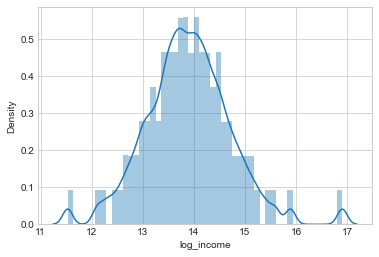

In [47]:
# Example with France
tmp = df[df.name == 'France']
sns.distplot(tmp.log_income)

<b> Transforming the income with a log function, help to normalize the data points and have a more Gaussian-like shape. </b> We can expect the model, to perform a bit better with this transformed variable.

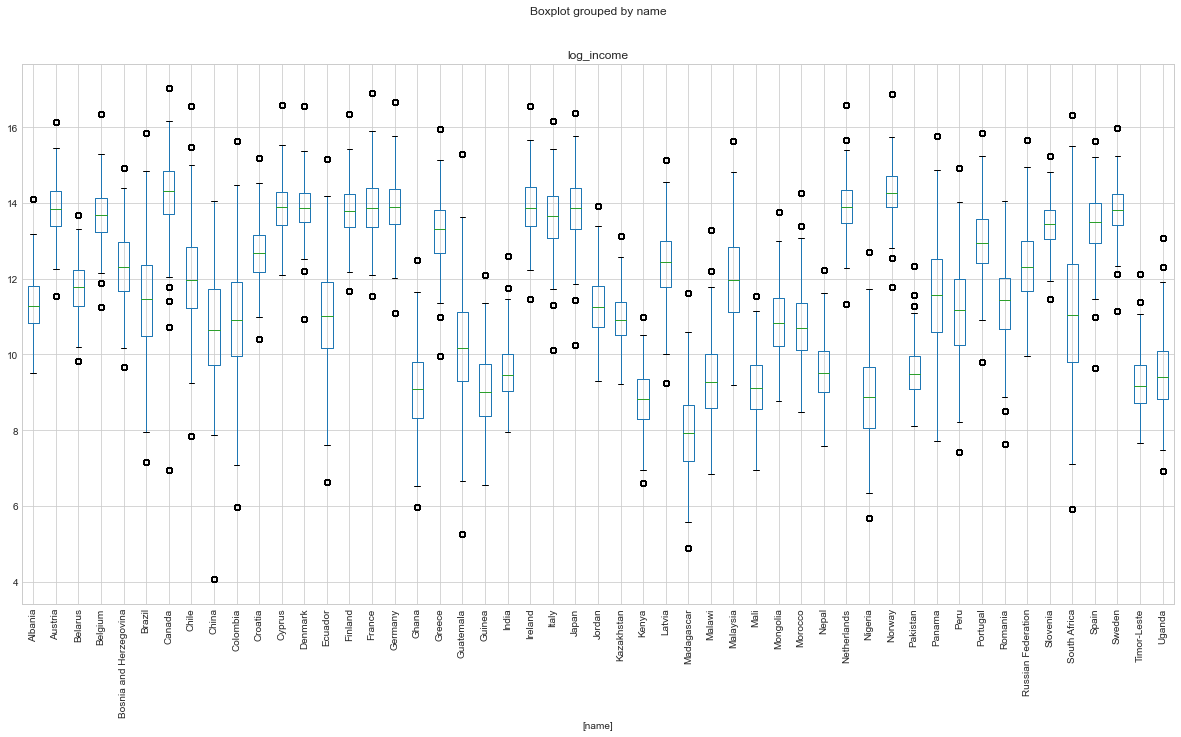

In [48]:
# Visualize the relationships between the 2 variables
tmp = df[['name','log_income']]
tmp.boxplot(by='name',figsize=(20,10))
plt.xticks(rotation=90)
plt.savefig(Path.cwd()/'Plot'/'BoxPlot_LOGIncome_Countries.png')
plt.show()

<b> We can see that depending on the country, the distribution of income can be really different. And also, that for some groups of countries, the distribution is very alike. </b> 

In [7]:
# ANOVA 1-way with log-income values
model2 = ols('log_income ~ C(name)',data = df).fit()
table2 = sm.stats.anova_lm(model2,type=2)
anova_table(table2)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(name),7.975793e+06,50.0,159515.854445,151384.799938,0.0,0.757368,0.757363
Residual,2.555139e+06,2424895.0,1.053711,NaN,NaN,NaN,NaN


<b> Using the log-income help to improve the model:</b>
- Eta-squared is now around 0.76 which is better than for the model with the income. It is still relatively low (we generally aim for at least 90%), probably because there are others important variables to explain the variability of incomes.


- The model sum of square is about 3 times higher than the error sum of square, which indicates that the country name is a pretty good parameter to explained and predict the income: 
    - Variability explained by the country equals = 7.975793e+06
    - Variability explained by other factors not included in the model = 2.555139e+06


- The MSE is high for the predictor (country name) but much lower than with the previous model. The MSE for the residual is around 1, which indicates again that the model is performing better than the previous model to fit and predict the data but could be improved.


<b> p-value << alpha risk (5%), meaning that at least one group is different than the rest (so that the income depend on the country). </b>
- The variability of income can be partly explained by the country we are observing, meaning that if we are observing the income from Angola or from Denmark, we can expect the income to be different. 

### ANOVA Assumptions

There are certain assumptions we need to verify for the ANOVA:

- <b> NORMALITY - The assumption of normality is tested on the residuals of the model.</b>
    - Can be verified using histograms and Q-Q plot, or using statistical tests such as Shapiro-Wilk.
    - With violations of normality, continuing with ANOVA is generally ok if you have a large sample size.
    
    
- <b> HOMOGENEITY of variance: Homogeneity means that the variance among the groups should be approximately equal. </b>
    - Can be tested using tests such as Levene’s test or the Brown-Forsythe Test.
    - In general, with violations of homogeneity, the analysis is considered robust if you have equal-sized groups.

 
- <b> INDEPENDENCE - The sample cases should be independent of each other.The observations are obtained independently and randomly from the population defined by the factor levels. </b>
    - can be verified with ACF (autocorrelation function) plots and Durbin-Watson test.
    - ANOVA is not robust to violations to the assumption of independence.

##### 1. Normality

/Users/aureliegiraud/.virtualenvs/env3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

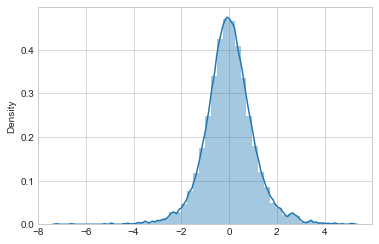

In [10]:
# Plot distribution to visualize the normality
sns.distplot(model2.resid)

<b> The distribution is relatively close to a normal distribution but we can detect some tails to the right and left and the kurtosis seems to be higher than the normal value. </b>

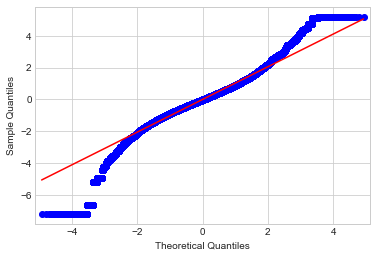

In [9]:
# Draw the Q-Q plot to visualize the adequation to the normality
qqplot(model2.resid, line='s')
pyplot.show()

<b> The distribution of residuals does not seem to follow a normal distribution:</b>
- We can see the 2 tails 
- It is not following the straight line (more like a S shape) 

In [20]:
# Just check the skewness value 
st.skew(model2.resid)

-0.011398371085222453

<b> For normally distributed data, the skewness should be about zero. </b> 
For unimodal continuous distributions, a skewness value lower than zero means that there is more weight in the left tail of the distribution.

Here the skewness is very small and very close to zero so close to a normal distribution.

In [23]:
# Just check the kurtosis value
st.kurtosis(model2.resid)

2.616544089626734

<b> For normally distributed data, the kurtosis should be about zero. </b> As expected after visualizing the distribution, the kurtosis of the residuals is much higher than the reference point (=0) of the Normal distribution. 

<b> Because we have a sample size > 5000, shapiro test is actually not ideal </b> (For N > 5000 the W test statistic is accurate but the p-value may not be). Let's test the Normality with Anderson and Darling. 

<b> Anderson-Darling test for data coming from a particular distribution. </b>
- H0 = The data is drawn from a population that follows a particular distribution, here the normal distribution. 
- H1 = The data is not drawn from a population that follows a Normal distribution

For the Anderson-Darling test, if the test statistic is higher than a critical value, the null hypothesis is rejected at the corresponding significance level (i.e there is evidence to suggest that the population doesn’t follow that particular distribution). 



In [18]:
# Test Normality with Anderson and Darling test
st.anderson(model2.resid,dist = 'norm')

AndersonResult(statistic=10248.77901675459, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

Here we see that the statistic value is very high and largely above any critical values. Again, the normality of the residuals is rejected.

<div class= 'alert alert-block alert-info'>
    <b> The one-way ANOVA is considered a robust test against the normality assumption. </b> This means that it tolerates violations to its normality assumption rather well. As regards the normality of group data, the one-way ANOVA can tolerate data that is non-normal (skewed or kurtotic distributions) with only a small effect on the Type I error rate (when the null hypothesis is true, but is rejected). 
However, platykurtosis (when the peak of the curve of frequency distribution is comparatively flatter than that of normal distribution) can have a profound effect when your group sizes are small. This leaves you with two options: (1) transform your data using various algorithms so that the shape of your distributions become normally distributed or (2) choose the nonparametric Kruskal-Wallis H Test which does not require the assumption of normality.

    
- source: 
    - https://statistics.laerd.com/statistical-guides/one-way-anova-statistical-guide-3.php
    - http://www.psicothema.com/pdf/4434.pdf
    
    
In a nutshell:     
- We are not in a situation with a platykurtosis distribution.
- The sample size is relatively big.
- The non-normality is likely due to an excess of kurtosis.

    
So, we might consider our model robust to the violation of this assumption.
    </div>

##### 2. Homogeneity

The assumption of homogeneity of variance is an assumption of the independent samples t-test and ANOVA stating that all comparison groups have the same variance.  The independent samples t-test and ANOVA utilize the t and F statistics respectively, which are generally robust to violations of the assumption as long as group sizes are equal.  Equal group sizes may be defined by the ratio of the largest to smallest group being less than 1.5. 

- source: https://www.statisticssolutions.com/the-assumption-of-homogeneity-of-variance/


One method for testing this assumption is the Levene's test of homogeneity of variances. If the data is not following a normal distribution Levene’s test is preferred over the Barlett’s test. 

Hypothesis for the Levene test:
- H0: The variances are equal across all samples/groups
- H1: The variances are not equal across all samples/groups

If we look at the box-plot above, we can expect that the test will show a significant difference between the variance, in others words, that the homoscedasticity is not verified.

In [30]:
# Test homoscedasticity by comparing the group (= countries) with dependent variable = log_income
pg.homoscedasticity(df, dv='log_income', group='name',method='levene')

,W,pval,equal_var
levene,5713.564274,0.0,False


In [17]:
# Check the size of the 'groups'
tmp = df.groupby('name').count()[['log_income']].reset_index()
print('min:', tmp['log_income'].min(), 'max',tmp['log_income'].max(),'ratio',tmp['log_income'].max()/tmp['log_income'].min())

min: 47468 max 47636 ratio 1.003539226426224


<div class= 'alert alert-block alert-info'>
<b> As expected, the condition of homogeneity of variances is not respected. </b>

Numerous investigations have examined the effects of variance heterogeneity on the empirical probability of a Type I error for the analysis of variance (ANOVA) F-test and the prevailing conclusion has been that when sample sizes are equal, the ANOVA is robust to variance heterogeneity. However, we should not assumed that the ANOVA F-test is always robust to variance heterogeneity when sample sizes are equal.

- source: https://doi.org/10.2307/1162346 
American Educational Research Journal
Vol. 14, No. 4 (Autumn, 1977), pp. 493-498 (6 pages)
Published By: American Educational Research Association


In this case study, we do not have strictly the same size for each groups however the differences are very small (<< 1,5 between the largest and the smallest group), so we might consider our model robust to the violation of this assumption. Alternatively, there are two tests that we could run that are applicable when the assumption of homogeneity of variances has been violated: (1) Welch or (2) Brown and Forsythe test. </div>

##### 3. Independance

Independence of residual is commonly referred to as the total absence of autocorrelation. Even though uncorrelated data does not necessarily imply independence, one can check if random variables are independent if their mutual information tends to 0.

We can use a Durbin and Watson test which calculates the Durbin-Watson statistic. The test will output values between 0 and 4. Here are how to interpret the results of the test:
- The closer to 2, the more evidence for no autocorrelation.
- The closer to 0 the statistic, the more evidence for positive serial correlation. 
- The closer to 4, the more evidence for negative serial correlation.

In [38]:
# Calculate Durbin and Watson statistic
tool.durbin_watson(model2.resid, axis=0)

0.0008159952809301728

<b> The result suggest a positive autocorrelation in the residuals. </b> So the condition of independance is not verified.

<div class= 'alert alert-block alert-warning'>
All in all, none of the conditions necessary for applying an ANOVA are verified here. So, even tough the model retrieved some relatively good performances we can not rely on it. 
    
Let's try to build another model based on multiple linear regression.
    </div>

### Linear Model

In order for our machine learning or deep learning model to work well, it is very often necessary for the data to have the same scale in terms of the Feature to avoid bias in the outcome. We will test the effect of scaling the data on the performances of the models.

In [73]:
# Standardized both independent and dependent variables
df['gini_sc'] = preprocessing.scale(df['new_gini'])
df['avginc_sc'] = preprocessing.scale(df['avg_income'])
df['class_sc'] = preprocessing.scale(df['c_i_parent'])
df['inc_sc'] = preprocessing.scale(df['income'])
df['loginc_sc'] = preprocessing.scale(df['log_income'])

In [75]:
# Different modalities tested
X1 = df[['new_gini','avg_income']]
X2 = df[['gini_sc','avginc_sc']]
X3 = df[['new_gini','avg_income','c_i_parent']]
X4 = df[['gini_sc','avginc_sc','class_sc']]

Y1 = df['income']
Y2 = df['inc_sc']
Y3 = df['log_income']
Y4 = df['loginc_sc']

#### Gini index & Average income (country) ~ Income

In [79]:
# with income and non-standardized data
x = sm.add_constant(X1) # let's add an intercept (beta_0) to our model
lin1 = sm.OLS(Y1, x).fit()
lin1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 income   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                 1.059e+06
Date:                Fri, 02 Apr 2021   Prob (F-statistic):               0.00
Time:                        13:15:53   Log-Likelihood:            -2.5053e+07
No. Observations:             2424946   AIC:                         5.011e+07
Df Residuals:                 2424943   BIC:                         5.011e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -18.2748     25.120     -0.727      0.467     -67.510      30.960
new_gini       0.5020      0.548      0.916      0.360      -0.572       1.577
avg_income     1.0001      0.001   1289.061      0.000       0.999       1.002
==============================================================================
Omnibus:                  2607390.809   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        296453827.484
Skew:                           5.356   Prob(JB):                         0.00
Kurtosis:                      56.097   Cond. No.                     5.49e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [80]:
# with income and standardized data
lin1_sc = sm.OLS(Y2, X2).fit()
lin1_sc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 inc_sc   R-squared (uncentered):                   0.466
Model:                            OLS   Adj. R-squared (uncentered):              0.466
Method:                 Least Squares   F-statistic:                          1.059e+06
Date:                Fri, 02 Apr 2021   Prob (F-statistic):                        0.00
Time:                        13:16:02   Log-Likelihood:                     -2.6798e+06
No. Observations:             2424946   AIC:                                  5.360e+06
Df Residuals:                 2424944   BIC:                                  5.360e+06
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
gini_sc        0.0005      0.001      0.916      0.360      -0.001       0.002
avginc_sc      0.6830      0.001   1289.061      0.000       0.682       0.684
==============================================================================
Omnibus:                  2607390.809   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        296453827.484
Skew:                           5.356   Prob(JB):                         0.00
Kurtosis:                      56.097   Cond. No.                         1.65
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<div class = 'alert alert-block alert-info'>  

<b> R-squared is relatively low in this model. </b>
    - about 0.47 using the income, meaning that 47% of the variance of the income can be explained by the gini index and the average income vs 53% can be explained by other factors not included in the model. 
    
    
<b> It is standard practice to use the coefficient p-values to decide whether to include variables in the final model. </b> For the results above, we would consider removing Gini Index because its pvalue >> 5%. Keeping variables that are not statistically significant can reduce the model’s precision.

</div>

In [81]:
# with log income and non-standardized data
x = sm.add_constant(X1) 
lin2 = sm.OLS(Y3, x).fit()
lin2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_income   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                 2.227e+06
Date:                Fri, 02 Apr 2021   Prob (F-statistic):               0.00
Time:                        13:16:09   Log-Likelihood:            -3.9572e+06
No. Observations:             2424946   AIC:                         7.914e+06
Df Residuals:                 2424943   BIC:                         7.915e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.8263      0.004   2347.127      0.000       9.818       9.834
new_gini       0.0002   9.14e-05      2.698      0.007    6.74e-05       0.000
avg_income     0.0002   1.29e-07   1870.105      0.000       0.000       0.000
==============================================================================
Omnibus:                    69625.341   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           169954.813
Skew:                          -0.104   Prob(JB):                         0.00
Kurtosis:                       4.280   Cond. No.                     5.49e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [88]:
# with log income and standardized data
x = sm.add_constant(X2) 
lin2_sc = sm.OLS(Y4, x).fit()
lin2_sc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              loginc_sc   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                 2.227e+06
Date:                Fri, 02 Apr 2021   Prob (F-statistic):               0.00
Time:                        13:32:09   Log-Likelihood:            -2.1767e+06
No. Observations:             2424946   AIC:                         4.353e+06
Df Residuals:                 2424943   BIC:                         4.353e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.784e-15      0.000   4.68e-12      1.000      -0.001       0.001
gini_sc        0.0012      0.000      2.698      0.007       0.000       0.002
avginc_sc      0.8052      0.000   1870.105      0.000       0.804       0.806
==============================================================================
Omnibus:                    69625.341   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           169954.813
Skew:                          -0.104   Prob(JB):                         0.00
Kurtosis:                       4.280   Cond. No.                         1.65
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<div class = 'alert alert-block alert-info'> 
    
<b> As expected, we get better results in terms of performances by using the log income than the income. </b>
R-squared is still relatively low but higher than with the income: about 0.65 using the log income, meaning that 65% of the variance of the log income can be explained by the gini index and the average income vs 35% can be explained by other factors not included in the model.
    

<b> Standardizing the independent variables is a simple method to reduce multicollinearity that is produced by higher-order terms. </b> We can see that we drop the warning [2] when we use standardized data. 

#### Parent's class + Gini index + Average income (country) ~ Income

In [84]:
# Linear Regression with income as dependent variable + parent's class as category
x = sm.add_constant(X3) 
lin3 = sm.OLS(Y1, x).fit()
lin3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 income   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                 8.049e+05
Date:                Fri, 02 Apr 2021   Prob (F-statistic):               0.00
Time:                        13:23:56   Log-Likelihood:            -2.4976e+07
No. Observations:             2424946   AIC:                         4.995e+07
Df Residuals:                 2424942   BIC:                         4.995e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3235.9899     25.642   -126.199      0.000   -3286.247   -3185.733
new_gini       0.5132      0.531      0.966      0.334      -0.528       1.554
avg_income     1.0002      0.001   1330.615      0.000       0.999       1.002
c_i_parent    63.7009      0.160    398.367      0.000      63.387      64.014
==============================================================================
Omnibus:                  2644289.626   Durbin-Watson:                   0.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        326384380.363
Skew:                           5.459   Prob(JB):                         0.00
Kurtosis:                      58.777   Cond. No.                     5.79e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.79e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [85]:
# Linear Regression with income as dependent variable + parent's class as category
x = sm.add_constant(X4) 
lin3_sc = sm.OLS(Y2, x).fit()
lin3_sc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 inc_sc   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                 8.049e+05
Date:                Fri, 02 Apr 2021   Prob (F-statistic):               0.00
Time:                        13:24:49   Log-Likelihood:            -2.6030e+06
No. Observations:             2424946   AIC:                         5.206e+06
Df Residuals:                 2424942   BIC:                         5.206e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.223e-16      0.000  -4.89e-13      1.000      -0.001       0.001
gini_sc        0.0005      0.001      0.966      0.334      -0.001       0.002
avginc_sc      0.6830      0.001   1330.615      0.000       0.682       0.684
class_sc       0.1811      0.000    398.367      0.000       0.180       0.182
==============================================================================
Omnibus:                  2644289.626   Durbin-Watson:                   0.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        326384380.363
Skew:                           5.459   Prob(JB):                         0.00
Kurtosis:                      58.777   Cond. No.                         1.65
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<div class = 'alert alert-block alert-info'>  

<b> R-squared is relatively low (about 50%) in this model. Adding the parent's classe improve the global performances of the model. </b>
Half of the variance of the income can be explained by the independent variables and half by other factors not included in the model. So this is not a very powerful model.
    
    
<b> It is standard practice to use the coefficient p-values to decide whether to include variables in the final model. </b> For the results above, we would consider removing Gini Index because its pvalue >> 5%. Keeping variables that are not statistically significant can reduce the model’s precision.
    
<b> Standardizing the independent variables has a positive effect on the risk of multicollinearity. </b> We can see that we drop the warning [2] when we use standardized data. 

</div>

In [86]:
# Linear Regression with log income as dependent variable 
x = sm.add_constant(X3) 
lin4 = sm.OLS(Y3, x).fit()
lin4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_income   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                 1.889e+06
Date:                Fri, 02 Apr 2021   Prob (F-statistic):               0.00
Time:                        13:29:52   Log-Likelihood:            -3.7603e+06
No. Observations:             2424946   AIC:                         7.521e+06
Df Residuals:                 2424942   BIC:                         7.521e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9884      0.004   2210.108      0.000       8.980       8.996
new_gini       0.0002   8.42e-05      2.961      0.003    8.43e-05       0.000
avg_income     0.0002   1.19e-07   2028.404      0.000       0.000       0.000
c_i_parent     0.0166   2.54e-05    653.997      0.000       0.017       0.017
==============================================================================
Omnibus:                    57545.715   Durbin-Watson:                   0.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           121372.071
Skew:                          -0.126   Prob(JB):                         0.00
Kurtosis:                       4.067   Cond. No.                     5.79e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.79e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [87]:
# Linear Regression with log income as dependent variable and standardized data
x = sm.add_constant(X4) 
lin4_sc = sm.OLS(Y4, x).fit()
lin4_sc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              loginc_sc   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                 1.889e+06
Date:                Fri, 02 Apr 2021   Prob (F-statistic):               0.00
Time:                        13:30:18   Log-Likelihood:            -1.9798e+06
No. Observations:             2424946   AIC:                         3.960e+06
Df Residuals:                 2424942   BIC:                         3.960e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.283e-15      0.000    6.5e-12      1.000      -0.001       0.001
gini_sc        0.0012      0.000      2.961      0.003       0.000       0.002
avginc_sc      0.8052      0.000   2028.404      0.000       0.804       0.806
class_sc       0.2299      0.000    653.997      0.000       0.229       0.231
==============================================================================
Omnibus:                    57545.715   Durbin-Watson:                   0.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           121372.071
Skew:                          -0.126   Prob(JB):                         0.00
Kurtosis:                       4.067   Cond. No.                         1.65
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<div class = 'alert alert-block alert-info'>  

<b> R-squared is relatively good (about 70%) in this model. Adding the parent's class improve the global performances of the model AND using the log income AND using standardized data retrieved the best performances. </b>
70% of the variance of the income can be explained by the independent variables and 30% remains explained by other factors not included in the model. 
    
    
<b> The Gini index is relevant in this model. </b> Its pvalue is below 5%. 
The coefficient associated to the gini index is positive - varying between 0,5 and 0,0002.
For the record, the higher is the gini index the higher are the inequalities. 
So, in a linear regression problem, type y = ax+b where:
- y = log_income
- x = gini index

if a > 0, it means that when gini index increases the child income increases even more rapidly. 
So, the models suggest that the more unequalitarian is the country, the more (some groups of) people benefit from the situation.
    
<b> Standardizing the independent variables has a positive effect on the risk of multicollinearity. </b> We can see that we drop the warning [2] when we use standardized data. 

</div>

<div class= 'alert alert-block alert-warning'> The last linear model, based on the gini index, the average income and the parent's class, is the one providing the best performances to predict the income (log transformed). Let's check if all the assumptions necessary for a linear model are verified. </div>

### Linear Model Assumptions

There are five assumptions which support using a linear regression model for the purpose of inference or prediction:
- <b> LINEARITY </b> : The relationship between the dependent variables and the independent variable is linear.
- <b> NORMALITY </b> : The residuals must follow a Normal distribution.
- <b> HOMOSCEDASTICITY </b> : The residuals have constant variance no matter the level of the dependent variable.
- <b> INDEPENDANCE </b> : Residuals must be totally free of autocorrelation.
- <b> ABSENCE OF MULTICOLLINEARITY </b> : Multicollinearity refers to when two predictors (or more) are providing the same information about the response variable.

#### 1. Linearity

Pearson correlation coefficient is used to measure the strength and direction of the linear relationship between two variables. 

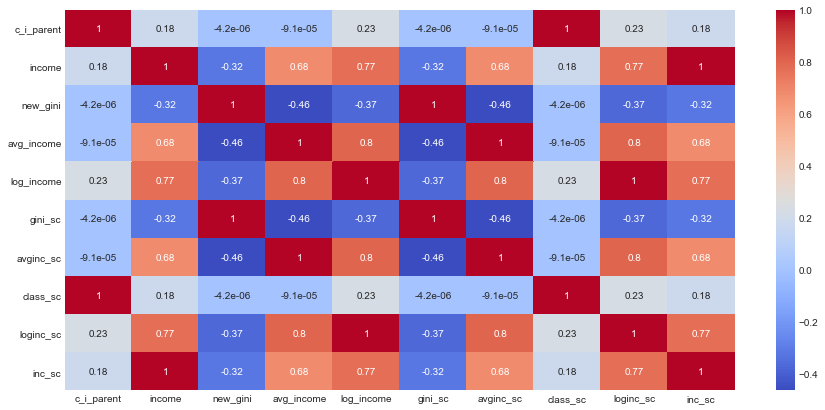

In [90]:
# correlation coefficients: By default, Pearson correlation coefficient is calculated
plt.subplots(figsize=(15,7))
sns.heatmap(df.corr(), annot = True, cmap='coolwarm')
plt.show()

<b> The linear relationship between the log-income and: </b> 
- the  average income is very strong
- the parent's class and the gini index is weak.

In [91]:
# Create samples from population set
samp_inc = df.sample(100)
samp_inc.head()

,name,c_i_parent,income,new_gini,avg_income,log_income,gini_sc,avginc_sc,class_sc,loginc_sc,inc_sc
1194008,Jordan,27,1313.2728,35.418291,3048.630976,10.358951,-0.345217,-0.681071,-0.813640,-0.651115,-0.636100
379416,Chile,72,45324.3750,54.611472,7051.609966,15.468000,1.609244,-0.104201,0.744244,1.800530,3.695142
1932224,Panama,61,4245.4820,54.645244,5135.139376,12.051713,1.612683,-0.380384,0.363428,0.161179,-0.347534
1704653,Nepal,93,1350.4761,34.492408,914.391651,10.399252,-0.439501,-0.988636,1.471256,-0.631776,-0.632439
1279901,Kazakhstan,42,3963.9626,28.449874,2239.149800,11.952728,-1.054818,-0.797725,-0.294346,0.113680,-0.375239


<AxesSubplot:xlabel='avg_income', ylabel='log_income'>

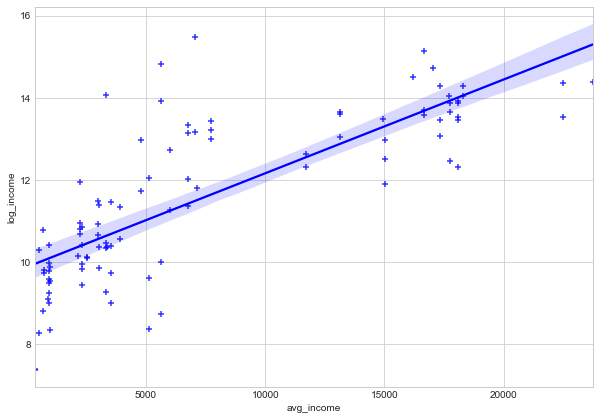

In [92]:
# regression plot using seaborn for average income
fig = plt.figure(figsize=(10, 7))
sns.regplot(x=samp_inc.avg_income, y=samp_inc.log_income, color='blue', marker='+')

<AxesSubplot:xlabel='new_gini', ylabel='log_income'>

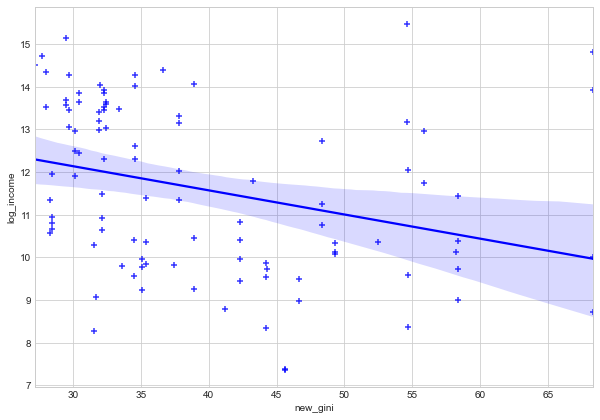

In [93]:
# regression plot using seaborn for gini index
fig = plt.figure(figsize=(10, 7))
sns.regplot(x=samp_inc.new_gini, y=samp_inc.log_income, color='blue', marker='+')

<AxesSubplot:xlabel='c_i_parent', ylabel='log_income'>

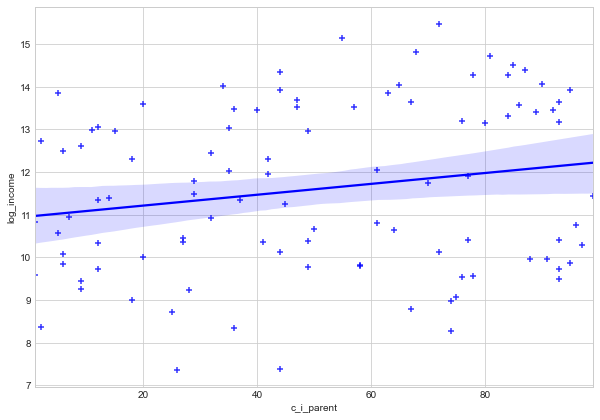

In [94]:
# regression plot using seaborn for parent's class
fig = plt.figure(figsize=(10, 7))
sns.regplot(x=samp_inc.c_i_parent, y=samp_inc.log_income, color='blue', marker='+')

<div class = 'alert alert-block alert-info ' > 
<b> The scatter plot confirm what we have seen in the Pearson's correlation factor. </b> Except for the average_income, the linear relationship between the log_income and the other independent variable is not really verified. </div>

#### 2. Normality 

/Users/aureliegiraud/.virtualenvs/env3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

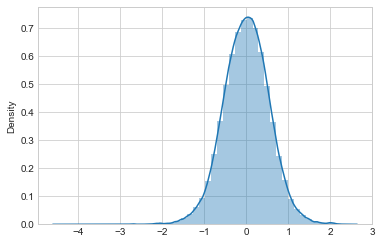

In [95]:
# Plot distribution to visualize the normality of residuals
sns.distplot(lin4_sc.resid)

<b> The distribution is relatively close to a normal distribution but the kurtosis seems to be higher than the normal value. </b>

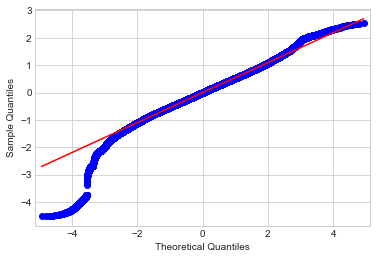

In [96]:
# Draw the Q-Q plot to visualize the adequation to the normality
qqplot(lin4_sc.resid, line='s')
pyplot.show()

<b> The distribution of residuals is very close to a normal distribution (following the straight line) but with a heavy left tail. </b>

<b> Anderson-Darling test for data coming from a particular distribution. </b>
- H0 = The data is drawn from a population that follows a particular distribution, here the normal distribution. 
- H1 = The data is not drawn from a population that follows a Normal distribution

For the Anderson-Darling test, if the test statistic is higher than a critical value, the null hypothesis is rejected at the corresponding significance level (i.e there is evidence to suggest that the population doesn’t follow that particular distribution). 

Here we see that the statistic value is very high and largely above any critical values. The normality of the residuals is rejected. Let's calculate the skewness and kurtosis.

In [97]:
# Test Normality with Anderson and Darling test
st.anderson(lin4_sc.resid,dist = 'norm')

AndersonResult(statistic=671.4683719398454, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [98]:
# Just check the skewness value 
st.skew(lin4_sc.resid)

-0.1259785470659593

<b> For normally distributed data, the skewness should be about zero. </b> 
For unimodal continuous distributions, a skewness value lower than zero means that there is more weight in the left tail of the distribution.

Here the skewness is relatively small and close to zero.

In [99]:
# Just check the kurtosis value
st.kurtosis(lin4_sc.resid)

1.0666548155220736

<b> For normally distributed data, the kurtosis should be about zero. </b> As expected after visualizing the distribution, the kurtosis of the residuals is greater than the reference point (=0) of the Normal distribution. 

<div class= 'alert alert-block alert-info'>
The condition of normality of the residuals is not verified however the distribution, skewness and kurtosis are very close to the Normal characteristic.
And, given the sample size of the data (N > 30 for each group) and according to the Central Limit Theorem, we are "protected" from violating this assumption and our findings will still be valid.
    
- source: http://www2.psychology.uiowa.edu/faculty/mordkoff/GradStats/part%201/I.07%20normal.pdf
    </div>

#### 3. Homogeneity

Hypothesis for the test:
- H0: The variances are equal --> the residual variance does not depend on the variables in x in the form
- H1: The variances are not equal.

In [100]:
# Test to verify the homoscedasticity of residuals
test = het_breuschpagan(lin4_sc.resid, lin4_sc.model.exog)
name = ['statistic', 'p-value',
        'f-value', 'f p-value']
lzip(name, test)

[('statistic', 72272.6394548307),
 ('p-value', 0.0),
 ('f-value', 24830.895468954946),
 ('f p-value', 0.0)]

<div class= 'alert alert-block alert-info'>
<b> The condition of homogeneity of variances is not respected. </b> The test is significant meaning the data violates the assumption of homoscedasticity, i.e. heteroscedasticity is present in the data. 
 </div>

#### 4. Independence

Independence of residual is commonly referred to as the total absence of autocorrelation. Even though uncorrelated data does not necessarily imply independence, one can check if random variables are independent if their mutual information tends to 0.

We can use a Durbin and Watson test which calculates the Durbin-Watson statistic. The test will output values between 0 and 4. Here are how to interpret the results of the test:
- The closer to 2, the more evidence for no autocorrelation.
- The closer to 0 the statistic, the more evidence for positive serial correlation. 
- The closer to 4, the more evidence for negative serial correlation.

In [101]:
# Calculate Durbin and Watson statistic
tool.durbin_watson(lin4_sc.resid, axis=0)

0.004796704911042385

<b> The result suggest a positive autocorrelation in the residuals. </b> So the condition of independance is not verified.

#### 2. Multicollinearity

We can check the existence of collinearity between two or more variables with the Variance Inflation Factor (VIF). It's a measure of colinearity among predictor variables within a multiple regression.

A rule of thumb for interpreting the variance inflation factor:

- 1 = not correlated.
- Between 1 and 5 = moderately correlated.
- Greater than 5 = highly correlated.

The more VIF increases, the less reliable your regression results are going to be. In general, a VIF above 10 indicates high correlation and is cause for concern. Some authors suggest a more conservative level of 2.5 or above. 

- source: https://www.statisticshowto.com/variance-inflation-factor/

In [103]:
# For each X, calculate VIF and save in dataframe
x3 = add_constant(X3)

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x3.values, i) for i in range(x3.shape[1])]
vif["features"] = x3.columns
vif.round(1) #inspect results

,VIF Factor,features
0,30.8,const
1,1.3,new_gini
2,1.3,avg_income
3,1.0,c_i_parent


<b> There is no collinearity between the features of the model. </b> Eventually, we can see a potential weak relationship between the gini index and the average income.

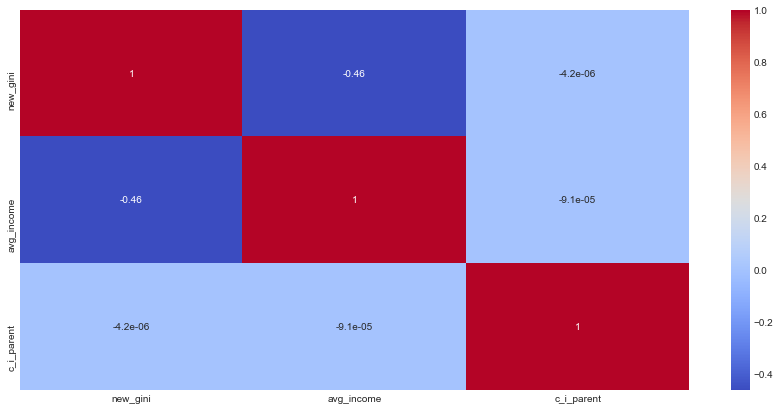

In [105]:
# Let's visualize the results
plt.subplots(figsize=(15,7))
sns.heatmap(X3.corr(), annot = True, cmap='coolwarm')
plt.show()

<b> The correlation matrix reveals indeed a light correlation between the gini index and the average income. </b> At this level, it shouldn't be a problem for our model. However, if it is, we should drop the gini index and keep the average income because we have already shown that there is a stronger linear relationship between the average income and the dependent variable.
